In [46]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import csv
import pandas as pd
import cv2
import shutil
import json
from tqdm import tqdm
import numpy as np
from PIL import Image
from utils.augmentations import letterbox, augment_hsv, random_perspective
import matplotlib.pyplot as plt
import onnx
from onnxsim import simplify
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import seaborn as sns

import os
import time
import random
import subprocess
import threading
from multiprocessing import Pool, Manager
from typing import Dict, List, Tuple, Union, Optional

In [47]:
CURRENT_DIR = os.getcwd()

DATASET_PATH = os.path.join(CURRENT_DIR, "dataset")

ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
ANNOTATIONS_CAPTION_TRAIN = "captions_train2017.json"
ANNOTATIONS_CAPTION_VAL = "captions_val2017.json"
ANNOTATIONS_INSTANCES_TRAIN = "instances_train2017.json"
ANNOTATIONS_INSTANCES_VAL = "instances_val2017.json"

FLICKR_TOKEN_PATH = os.path.join(DATASET_PATH, "flickr30k", "results_20130124.token")

TRAIN_IMAGE_PATH = os.path.join(DATASET_PATH, "images/train")
VAL_IMAGE_PATH = os.path.join(DATASET_PATH, "images/val")
TEST_IMAGE_PATH = os.path.join(DATASET_PATH, "images/test")

PREPROCESS_DATA_PATH = os.path.join(DATASET_PATH, "preprocess")
PREPROCESS_FEATURES_TRAIN = "features_train.bin"
PREPROCESS_FEATURES_VAL = "features_val.bin"
PREPROCESS_INFO_TRAIN = "info_train.pkl"
PREPROCESS_INFO_VAL = "info_val.pkl"
PREPROCESS_INFO_CATEGORIES_TRAIN = "info_categories_train.pkl"
PREPROCESS_INFO_CATEGORIES_VAL = "info_categories_val.pkl"
PREPROCESS_INFO_TEST = "info_test.pkl"
PREPROCESS_CAPTION_CLEANED_TRAIN = "captions_cleaned_train.bin"
PREPROCESS_CAPTION_CLEANED_VAL = "captions_cleaned_val.bin"
PREPROCESS_CAPTION_CLEANED_TEST = "captions_cleaned_test.bin"
PREPROCESS_VOCABULARY = "vocabulary.txt"

MODEL_PATH = os.path.join(CURRENT_DIR, "pre-trained_model")
YOLOV5_MODEL_PATH = os.path.join(MODEL_PATH, "yolov5s.pt")

OUTPUT_MODEL_PATH = os.path.join(CURRENT_DIR, "output")
DECODER_MODEL_PATH = os.path.join(OUTPUT_MODEL_PATH, "decoder-best.pt")
PREDICTIONS_VAL_PATH = os.path.join(OUTPUT_MODEL_PATH, "predictions_val.json")
PREDICTIONS_TEST_PATH = os.path.join(OUTPUT_MODEL_PATH, "predictions_test.json")
EVALUATION_VAL_PATH = os.path.join(OUTPUT_MODEL_PATH, "evaluation_val.json")
EVALUATION_TEST_PATH = os.path.join(OUTPUT_MODEL_PATH, "evaluation_test.json")
CATEGORIES_SCORE_TABLE_VAL_PATH = os.path.join(OUTPUT_MODEL_PATH, "categories_scores_val.csv")

EXPORT_MODEL_PATH = os.path.join(CURRENT_DIR, "export")

EVAL_PATH = os.path.join(CURRENT_DIR, "eval")
EVAL_METEOR_PATH = os.path.join(EVAL_PATH, "meteor-1.5")
EVAL_METEOR_JAR_PATH = os.path.join(EVAL_METEOR_PATH, "meteor-1.5.jar")

USE_CACHE = True
MULTIPROCESSING = True
SHOW_IMAGE_AND_PLOT = "get_ipython" in dir()
DATA_AUGMENTATION = False
TRAIN_WITH_ENCODER = False
VOCABULARY_IGNORE_MIN_FREQUENCY = 4

In [48]:
# Disable opencv multiprocess for PyTorch DataLoader
# noinspection PyUnresolvedReferences
cv2.setNumThreads(0)

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    print("Current dir:", CURRENT_DIR)
    print("Show image and plot:", SHOW_IMAGE_AND_PLOT)
    if SHOW_IMAGE_AND_PLOT:
        sns.set_theme()

Device: cuda
Current dir: c:\Users\xfy93\Projects\PycharmProjects\ImageCaption
Show image and plot: True


In [4]:
class CSPDarkNet53Head(nn.Module):
    def __init__(self, yolov5_pt: str):
        super(CSPDarkNet53Head, self).__init__()
        model = torch.load(yolov5_pt, map_location="cpu")["model"]
        self.backbone = nn.Sequential(*list(model.children())[0][:9])

    def forward(self, x):
        return self.backbone(x)


class EncoderCNN(nn.Module):
    def __init__(self, encoder_head: Optional[nn.Module] = None):
        super(EncoderCNN, self).__init__()
        if encoder_head is not None:
            self.head = encoder_head
            for param in self.head.parameters():
                param.requires_grad_(False)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

    def forward(self, x):
        if hasattr(self, "head"):
            x = self.head(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        return x

In [5]:
# From yolov5 utils/dataloaders.py LoadImages
# Norms 255 Means 0
# Letter box padding 114
# YoloV5 S 6.1 --- fp16 640*640
# noinspection PyUnresolvedReferences
def image_preprocess(img_path: str, dynamic_size: bool = True) -> np.ndarray:
    img = cv2.imread(img_path)
    img, _, _ = letterbox(img, new_shape=(640, 640), auto=dynamic_size, color=(114, 114, 114))
    return img


def image_data_augmentation(img: np.ndarray) -> np.ndarray:
    img, _ = random_perspective(img)
    augment_hsv(img, hgain=0.015, sgain=0.7, vgain=0.4)
    if random.random() < 0.5:
        img = np.fliplr(img)
    return img


def image_postprocess(img: np.ndarray) -> Tensor:
    img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img = np.ascontiguousarray(img)
    tensor = torch.from_numpy(img) / 255
    return tensor.half()

In [6]:
class CocoImageDataset(Dataset):
    def __init__(self, image_dir: str, dynamic_size: bool, data_augmentation: bool, enable_cache: bool = False):
        self._image_dir = image_dir
        self._dynamic_size = dynamic_size
        self._data_augmentation = data_augmentation
        self._images = [p for p in os.listdir(self._image_dir) if not p.startswith(".")]
        self._cache = {}
        self._enable_cache = enable_cache

    def get_item_by_image_file_name(self, file_name: str):
        image_id = int(file_name[:file_name.rindex(".")])
        if self._enable_cache and image_id in self._cache:
            image = self._cache[image_id]
        else:
            img_path = os.path.join(self._image_dir, file_name)
            image = image_preprocess(img_path, self._dynamic_size)
            if self._enable_cache:
                self._cache[image_id] = image
        if self._data_augmentation:
            image = image_data_augmentation(image)
        tensor = image_postprocess(image)
        return tensor, image_id

    def __getitem__(self, idx):
        file_name = self._images[idx]
        return self.get_item_by_image_file_name(file_name)

    def __len__(self) -> int:
        return len(self._images)

In [7]:
def processing_image(encoder: EncoderCNN, image_path: str, data_augmentation: bool) -> dict:
    dataset = CocoImageDataset(image_path, True, data_augmentation)
    features = {}
    for image, label in tqdm(dataset):
        inputs = image.to(device).unsqueeze(0)
        outputs = encoder(inputs)
        features[label] = outputs
    return features


def load_image_features(encoder: EncoderCNN, image_path: str, features_name: str, data_augmentation: bool) -> dict:
    features_path = os.path.join(PREPROCESS_DATA_PATH, features_name)
    if not USE_CACHE or not os.path.isfile(features_path):
        features = processing_image(encoder, image_path, data_augmentation)
        print(f"Extracted {len(features)} features")
        torch.save(features, features_path)
        return features
    else:
        print(f"Loading cache from {features_name}")
        features = torch.load(features_path, map_location="cpu")
        print(f"Load {len(features)} caches")
        return {int(k): v for k, v in features.items()}


In [8]:
if __name__ == '__main__':
    if TRAIN_WITH_ENCODER:
        print("Training with encoder!")
    else:
        ENCODER = EncoderCNN(CSPDarkNet53Head(YOLOV5_MODEL_PATH)).to(device).eval()
        FEATURES_TRAIN = load_image_features(ENCODER, TRAIN_IMAGE_PATH, PREPROCESS_FEATURES_TRAIN, DATA_AUGMENTATION)
        FEATURES_VAL = load_image_features(ENCODER, VAL_IMAGE_PATH, PREPROCESS_FEATURES_VAL, DATA_AUGMENTATION)
        print("Train output shape:", FEATURES_TRAIN[9].shape)
        print("Val output shape:", FEATURES_VAL[139].shape)

Loading cache from features_train.bin
Load 118287 caches
Loading cache from features_val.bin
Load 5000 caches
Train output shape: torch.Size([1, 512])
Val output shape: torch.Size([1, 512])


In [9]:
def generate_caption_dataset(annotation_path: str) -> pd.DataFrame:
    with open(annotation_path) as f:
        json_file = json.load(f)
        images = pd.json_normalize(json_file, record_path=['images'])
        cations = pd.json_normalize(json_file, record_path=['annotations'])
    images = images[["id", "file_name"]].drop_duplicates().rename(columns={"id": "image_id"})
    dataset = pd.merge(cations, images, on="image_id")
    return dataset


def load_caption_dataset(annotation_name: str, caption_name: str) -> pd.DataFrame:
    annotation_path = os.path.join(ANNOTATIONS_PATH, annotation_name)
    caption_path = os.path.join(PREPROCESS_DATA_PATH, caption_name)
    if not USE_CACHE or not os.path.isfile(caption_path):
        print(f"Reading captions into {caption_name}")
        df = generate_caption_dataset(annotation_path)
        df.to_pickle(caption_path)
        return df
    else:
        print(f"Loading cache from {caption_name}")
        return pd.read_pickle(caption_path)


def generate_categories_dataset(annotation_path: str) -> pd.DataFrame:
    with open(annotation_path) as f:
        json_file = json.load(f)
        categories = pd.json_normalize(json_file, record_path=['annotations'])
        labels = pd.json_normalize(json_file, record_path=['categories'])
    categories = categories[["id", "category_id", "image_id"]].drop_duplicates()
    labels = labels[["id", "name"]].drop_duplicates().rename(columns={"id": "category_id"})
    dataset = pd.merge(categories, labels, on="category_id")
    return dataset


def load_categories_dataset(annotation_name: str, categories_name: str) -> pd.DataFrame:
    annotation_path = os.path.join(ANNOTATIONS_PATH, annotation_name)
    categories_path = os.path.join(PREPROCESS_DATA_PATH, categories_name)
    if not USE_CACHE or not os.path.isfile(categories_path):
        print(f"Reading categories into {categories_name}")
        df = generate_categories_dataset(annotation_path)
        df.to_pickle(categories_path)
        return df
    else:
        print(f"Loading cache from {categories_name}")
        return pd.read_pickle(categories_path)

In [10]:
if __name__ == '__main__':
    INFO_DF_TRAIN = load_caption_dataset(ANNOTATIONS_CAPTION_TRAIN, PREPROCESS_INFO_TRAIN)
    INFO_DF_VAL = load_caption_dataset(ANNOTATIONS_CAPTION_VAL, PREPROCESS_INFO_VAL)

Loading cache from info_train.pkl
Loading cache from info_val.pkl


In [11]:
if __name__ == '__main__':
    INFO_CATEGORIES_TRAIN = load_categories_dataset(ANNOTATIONS_INSTANCES_TRAIN, PREPROCESS_INFO_CATEGORIES_TRAIN)
    INFO_CATEGORIES_VAL = load_categories_dataset(ANNOTATIONS_INSTANCES_VAL, PREPROCESS_INFO_CATEGORIES_VAL)

Loading cache from info_categories_train.pkl
Loading cache from info_categories_val.pkl


In [12]:
def calculate_max_seq_length(*args: Dict[int, List[str]]) -> int:
    max_seq = 0
    for data in args:
        for k, v in data.items():
            max_seq = max(max_seq, len(v))
    return max_seq + 1


def clean_caption(caption: str) -> List[str]:
    content = ''.join([c for c in caption.lower() if c.isalpha() or c == " "])
    return [w.strip() for w in content.split(" ") if not w.strip().isspace() and len(w.strip()) > 0]


def get_cleaned_captions(df: pd.DataFrame) -> Dict[int, List[str]]:
    result = {}
    for _, row in df.iterrows():
        result[row["id"]] = clean_caption(row["caption"])
    return result


def load_cleaned_captions(df: pd.DataFrame, caption_name: str) -> Dict[int, List[str]]:
    caption_path = os.path.join(PREPROCESS_DATA_PATH, caption_name)
    if not USE_CACHE or not os.path.isfile(caption_path):
        print(f"Cleaning captions into {caption_name}")
        result = get_cleaned_captions(df)
        torch.save(result, caption_path)
        return result
    else:
        print(f"Loading cache from {caption_name}")
        return torch.load(caption_path, map_location="cpu")

In [13]:
if __name__ == '__main__':
    CLEANED_CAPTIONS_TRAIN = load_cleaned_captions(INFO_DF_TRAIN, PREPROCESS_CAPTION_CLEANED_TRAIN)
    CLEANED_CAPTIONS_VAL = load_cleaned_captions(INFO_DF_VAL, PREPROCESS_CAPTION_CLEANED_VAL)
    MAX_SEQ = calculate_max_seq_length(CLEANED_CAPTIONS_TRAIN, CLEANED_CAPTIONS_VAL)
    print("Max seq:", MAX_SEQ)

Loading cache from captions_cleaned_train.bin
Loading cache from captions_cleaned_val.bin
Max seq: 50


In [14]:
class Vocabulary(object):
    padding = '<pad>'
    unknown = '<unk>'
    end = '<end>'

    def __init__(self, words_list: Optional[List[str]] = None):
        if words_list is None:
            self._words_list = [self.padding, self.unknown, self.end]
        else:
            self._words_list = words_list
        self._word2idx = {k: v for v, k in enumerate(self._words_list)}

    def add(self, word: str):
        if not word in self._words_list:
            self._word2idx[word] = len(self._words_list)
            self._words_list.append(word)

    def save(self, save_path: str):
        with open(save_path, 'w', encoding="utf-8", newline="\n") as f:
            f.write("\n".join(self._words_list))

    @staticmethod
    def load(load_path: str):
        with open(load_path, 'r', encoding="utf-8", newline="\n") as f:
            vocab = Vocabulary([i.strip() for i in f.readlines() if not i.isspace()])
        return vocab

    def __getitem__(self, item: Union[str, int]) -> Union[int, str]:
        if isinstance(item, str):
            if item not in self._word2idx:
                return self._word2idx[self.unknown]
            else:
                return self._word2idx[item]
        elif isinstance(item, int):
            if item < 0 or item > len(self._words_list):
                return self.unknown
            else:
                return self._words_list[item]
        else:
            raise ValueError(item)

    def __len__(self):
        return len(self._words_list)


In [15]:
def calculate_word_frequency(words_frequency: dict, caption_cleaned_dict: Dict[int, List[str]]):
    for _, words in caption_cleaned_dict.items():
        for word in words:
            if word in words_frequency:
                words_frequency[word] += 1
            else:
                words_frequency[word] = 1


def create_vocabulary(ignore: int, *args: Dict[int, List[str]]) -> Vocabulary:
    words_frequency = {}
    for data in args:
        calculate_word_frequency(words_frequency, data)
    vocabulary = Vocabulary()
    for word, count in words_frequency.items():
        if count > ignore:
            vocabulary.add(word)
    return vocabulary


def load_vocabulary(ignore: int, *args: dict) -> Vocabulary:
    vocab_path = os.path.join(PREPROCESS_DATA_PATH, PREPROCESS_VOCABULARY)
    if not USE_CACHE or not os.path.isfile(vocab_path):
        print(f"Creating vocabulary")
        vocab = create_vocabulary(ignore, *args)
        vocab.save(vocab_path)
        return vocab
    else:
        print(f"Loading vocabulary cache")
        return Vocabulary.load(vocab_path)

In [16]:
if __name__ == '__main__':
    VOCABULARY = load_vocabulary(
        VOCABULARY_IGNORE_MIN_FREQUENCY,
        CLEANED_CAPTIONS_TRAIN,
        CLEANED_CAPTIONS_VAL
    )
    print(f"Vocabulary size: {len(VOCABULARY)}")
    print(f"Vocabulary min frequency: {VOCABULARY_IGNORE_MIN_FREQUENCY}")

Loading vocabulary cache
Vocabulary size: 10410
Vocabulary min frequency: 4


In [17]:
def calculate_max_seq_length(*args: Dict[int, List[str]]) -> int:
    max_seq = 0
    for data in args:
        for k, v in data.items():
            max_seq = max(max_seq, len(v))
    return max_seq + 1


def word2vec(vocab: Vocabulary, max_seq: int, words: List[str]) -> Tuple[Tensor, Tensor]:
    vector = torch.empty(max_seq, dtype=torch.int64)
    idx = 0
    for w in words:
        vector[idx] = vocab[w]
        idx += 1
    vector[idx] = vocab[Vocabulary.end]
    idx += 1
    for i in range(idx, max_seq):
        vector[i] = vocab[Vocabulary.padding]
    length = torch.tensor(idx, dtype=torch.int64)
    return vector, length

In [18]:
class CocoFeatureCaptionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: Vocabulary, max_seq: int, captions: Dict[int, List[str]], features: dict):
        self._df = df
        self._features = features
        self._captions = captions
        self._vocab = vocab
        self._max_seq = max_seq

    def __getitem__(self, index):
        row = self._df.iloc[index]
        image_id = row["image_id"]
        item_id = row["id"]
        features = self._features[image_id]
        caption_tensor, length_tensor = word2vec(self._vocab, self._max_seq, self._captions[item_id])
        # YoloV5s pre-trained is fp16 model
        return features.squeeze(0), caption_tensor, length_tensor

    def __len__(self):
        return len(self._df)


class CocoImageCaptionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: Vocabulary, max_seq: int, captions: Dict[int, List[str]], image_dir: str, data_augmentation: bool):
        self._df = df
        self._image_dataset = CocoImageDataset(image_dir, False, data_augmentation)
        self._captions = captions
        self._vocab = vocab
        self._max_seq = max_seq

    def __getitem__(self, index):
        row = self._df.iloc[index]
        file_name = row["file_name"]
        item_id = row["id"]
        img, _ = self._image_dataset.get_item_by_image_file_name(file_name)
        caption_tensor, length_tensor = word2vec(self._vocab, self._max_seq, self._captions[item_id])
        return img, caption_tensor, length_tensor

    def __len__(self):
        return len(self._df)


def check_vector_shape(data_loader: DataLoader):
    data_loader_iter = iter(data_loader)
    features, captions, lengths = next(data_loader_iter)
    print("Features:", features.shape, features.dtype)
    print("Captions:", captions.shape, captions.dtype)
    print("Length:", lengths.shape, captions.dtype)

In [19]:
if __name__ == '__main__':
    if TRAIN_WITH_ENCODER:
        DATASET_TRAIN = CocoImageCaptionDataset(INFO_DF_TRAIN, VOCABULARY, MAX_SEQ, CLEANED_CAPTIONS_TRAIN, TRAIN_IMAGE_PATH, DATA_AUGMENTATION)
        DATASET_VAL = CocoImageCaptionDataset(INFO_DF_VAL, VOCABULARY, MAX_SEQ, CLEANED_CAPTIONS_VAL, VAL_IMAGE_PATH, False)
    else:
        DATASET_TRAIN = CocoFeatureCaptionDataset(INFO_DF_TRAIN, VOCABULARY, MAX_SEQ, CLEANED_CAPTIONS_TRAIN, FEATURES_TRAIN)
        DATASET_VAL = CocoFeatureCaptionDataset(INFO_DF_VAL, VOCABULARY, MAX_SEQ, CLEANED_CAPTIONS_VAL, FEATURES_VAL)

    DATALOADER_TRAIN = DataLoader(
        dataset=DATASET_TRAIN,
        batch_size=128,
        shuffle=True,
        num_workers=6 if MULTIPROCESSING else 0
    )
    DATALOADER_VAL = DataLoader(
        dataset=DATASET_VAL,
        batch_size=256,
        num_workers=4 if MULTIPROCESSING else 0
    )

    print("Train data set size:", len(DATASET_TRAIN))
    print("Val data set size:", len(DATASET_VAL))

    # print("Train vectors shape:")
    # check_vector_shape(DATALOADER_TRAIN)

    # print("Val vectors shape:")
    # check_vector_shape(DATALOADER_VAL)

Train data set size: 591753
Val data set size: 25014


In [20]:
class DecoderRNNBase(nn.Module):
    def __init__(self, vocab_size: int, features_size: int = 512, embed_size: int = 256, hidden_size: int = 512, dropout: float = 0.5):
        super(DecoderRNNBase, self).__init__()
        self.vocab_size = vocab_size
        self.features_size = features_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size

        # Image features
        self.resize = nn.Linear(features_size, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)  # 1 256

        # Captions
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)

        # Output
        self.dp = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)


class DecoderRNN(DecoderRNNBase):
    def __init__(self, vocab_size: int, features_size: int = 512, embed_size: int = 256, hidden_size: int = 512, dropout: float = 0.5):
        super(DecoderRNN, self).__init__(vocab_size, features_size, embed_size, hidden_size, dropout)

    def forward(self, features: Tensor, captions: Tensor, lengths: Tensor) -> Tensor:
        # Image features
        features = self.resize(features)
        features = self.bn(features)  # 1 256

        # Captions
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        # Mini batch pack
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)

        # RNN
        hidden, _ = self.gru(packed)

        # Output
        outputs = self.dp(hidden.data)
        outputs = self.fc(outputs)

        return outputs


class Seq2seqTrain(nn.Module):
    def __init__(self, yolov5_path: str, vocab_size: int):
        super(Seq2seqTrain, self).__init__()
        encoder_cnn = EncoderCNN(CSPDarkNet53Head(yolov5_path))
        for param in encoder_cnn.parameters():
            param.requires_grad_(False)
        self.encoder = encoder_cnn.eval()
        self.decoder = DecoderRNN(vocab_size)

    def forward(self, img: Tensor, captions: Tensor, lengths: Tensor) -> Tensor:
        out = self.encoder(img)
        out = self.decoder(out, captions, lengths)
        return out

In [21]:
def step_epoch(
        model: nn.Module,
        data_loader: DataLoader,
        train: bool,
        loss_function: nn.Module,
        optimizer,
        grad_scaler: Optional[GradScaler]
) -> float:
    sum_loss = 0
    amount = 0

    grad_status = torch.is_grad_enabled()
    if train:
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)

    for features, captions, lengths in tqdm(data_loader):
        features, captions, lengths = features.to(device), captions.to(device), lengths

        if train:
            optimizer.zero_grad()

        with autocast():
            outputs = model(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False).data
            loss = loss_function(outputs, targets)

        if train:
            if grad_scaler is not None:
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()
            else:
                loss.backward()
                optimizer.step()

        sum_loss += loss
        amount += 1

    torch.set_grad_enabled(grad_status)

    return sum_loss / amount


def append_train_stat_csv(
        output_dir: str,
        stat_header: List[str],
        stat_data: list
):
    stat_path = os.path.join(output_dir, "stat.csv")
    exists_csv = os.path.isfile(stat_path)
    with open(stat_path, "a", encoding="utf-8") as f:
        writer = csv.writer(f, lineterminator='\n')
        if not exists_csv:
            writer.writerow(stat_header)
        writer.writerow(stat_data)


def train_model(
        epochs_start_inclusive: int,
        epochs_end_exclusive: int,
        model: nn.Module,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        loss_function: nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler,
        output_dir: str,
        save_model: bool
):
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    stat_header = ["train_loss", "val_loss"]
    grad_scaler = GradScaler()
    for epoch in range(epochs_start_inclusive, epochs_end_exclusive):
        start_time = time.time()
        # Train
        training_loss = step_epoch(model, train_dataloader, True, loss_function, optimizer, grad_scaler)
        validation_loss = step_epoch(model, val_dataloader, False, loss_function, optimizer, None)
        scheduler.step(validation_loss)
        end_time = time.time()

        # Print
        training_loss = training_loss.cpu().detach().numpy()
        validation_loss = validation_loss.cpu().detach().numpy()
        print_epoch(epoch, training_loss, validation_loss, int(end_time - start_time))
        append_train_stat_csv(output_dir, stat_header, [training_loss, validation_loss])

        if save_model:
            output_path = os.path.join(output_dir, f"ckpt_{epoch}.pt")
            if hasattr(model, "decoder"):
                torch.save({"model": model.decoder.state_dict()}, output_path)
            else:
                torch.save({"model": model.state_dict()}, output_path)


def print_epoch(epoch: int, training_loss: float, validation_loss: float, seconds: Optional[int] = None):
    if seconds is None:
        print(f"Epoch {epoch + 1: > 3} -> Train loss: {training_loss: .4f}  Val loss: {validation_loss: .4f}")
    else:
        print(f"Epoch {epoch + 1: > 3} -> Train loss: {training_loss: .4f}  Val loss: {validation_loss: .4f}  Seconds: {seconds}")


def print_ckpt_epoch(output_dir: str):
    stat_path = os.path.join(output_dir, "stat.csv")
    df = pd.read_csv(stat_path)
    for i, row in df.iterrows():
        print_epoch(i, row["train_loss"], row["val_loss"])


def get_latest_ckpt(output_dir: str) -> Optional[Tuple[str, int]]:
    if os.path.isdir(output_dir):
        ckpt_files = [(p, int(p[len("ckpt_"):-len(".pt")])) for p in os.listdir(output_dir) if p.startswith("ckpt_") and p.endswith(".pt")]
        if len(ckpt_files) > 0:
            ckpt_files.sort(key=lambda x: x[1], reverse=True)
            return ckpt_files[0]
    return None

In [22]:
if __name__ == '__main__':
    CONTINUE_TRAINING = False
    TOTAL_EPOCHS = 150
    LEARNING_RATE = 0.1
    SCHEDULER_FACTOR = 0.1
    SCHEDULER_PATIENCE = 3
    SAVE_MODEL = True

    if not USE_CACHE or not (os.path.isdir(OUTPUT_MODEL_PATH) and len(os.listdir(OUTPUT_MODEL_PATH)) > 0) or CONTINUE_TRAINING:
        CURRENT_EPOCH = 0
        if TRAIN_WITH_ENCODER:
            MODEL = Seq2seqTrain(YOLOV5_MODEL_PATH, len(VOCABULARY)).to(device)
        else:
            MODEL = DecoderRNN(len(VOCABULARY)).to(device)
        if CONTINUE_TRAINING:
            LATEST_CKPT = get_latest_ckpt(OUTPUT_MODEL_PATH)
            if LATEST_CKPT is not None:
                if LATEST_CKPT[1] >= TOTAL_EPOCHS - 1:
                    print("Training already finished!")
                else:
                    CURRENT_EPOCH = LATEST_CKPT[1] + 1

                    LATEST_CKPT_STATE_DICT = torch.load(os.path.join(OUTPUT_MODEL_PATH, LATEST_CKPT[0]), map_location=device)["model"]

                    if TRAIN_WITH_ENCODER:
                        MODEL.decoder.load_state_dict(LATEST_CKPT_STATE_DICT)
                    else:
                        MODEL.load_state_dict(LATEST_CKPT_STATE_DICT)

                    print(f"Continue training from epoch {LATEST_CKPT[1] + 1}")
                print_ckpt_epoch(OUTPUT_MODEL_PATH)
            else:
                MODEL = None
                CURRENT_EPOCH = TOTAL_EPOCHS - 1
                print("Failed to continue training!")

        if MODEL is not None:
            LOSS_FUNCTION = nn.CrossEntropyLoss(ignore_index=VOCABULARY[Vocabulary.padding]).to(device)
            OPTIMIZER = torch.optim.SGD(MODEL.parameters(), lr=LEARNING_RATE)
            SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=True)

            print("Training start")
            train_model(
                epochs_start_inclusive=CURRENT_EPOCH,
                epochs_end_exclusive=TOTAL_EPOCHS,
                model=MODEL,
                train_dataloader=DATALOADER_TRAIN,
                val_dataloader=DATALOADER_VAL,
                loss_function=LOSS_FUNCTION,
                optimizer=OPTIMIZER,
                scheduler=SCHEDULER,
                output_dir=OUTPUT_MODEL_PATH,
                save_model=SAVE_MODEL
            )
            print("Training finished!")
    else:
        print("Model output dir exists!")

Model output dir exists!


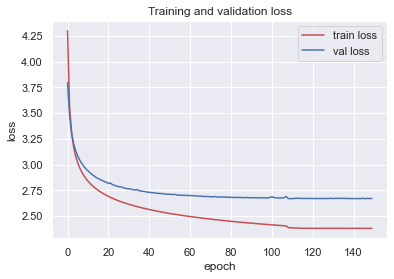

In [49]:
def plot_model_stat(output_dir: str):
    stat_path = os.path.join(output_dir, "stat.csv")
    df = pd.read_csv(stat_path)
    plt.plot(df["train_loss"], 'r', label="train loss")
    plt.plot(df["val_loss"], 'b', label="val loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title('Training and validation loss')
    plt.show()


if __name__ == '__main__':
    if SHOW_IMAGE_AND_PLOT:
        if "get_ipython" in dir():
            # pyright: reportUndefinedVariable=false
            get_ipython().run_line_magic('matplotlib', 'inline')
        plot_model_stat(OUTPUT_MODEL_PATH)

In [24]:
def pick_epoch_from_check_point(output_dir: str, epoch: int, export_path: str):
    if not USE_CACHE or not os.path.isfile(export_path):
        ckpt_file_path = os.path.join(output_dir, f"ckpt_{epoch}.pt")
        if os.path.isfile(export_path):
            os.remove(export_path)
        shutil.copyfile(ckpt_file_path, export_path)

In [25]:
if __name__ == '__main__':
    BEST_EPOCH = 150
    pick_epoch_from_check_point(OUTPUT_MODEL_PATH, BEST_EPOCH - 1, DECODER_MODEL_PATH)

In [26]:
class DecoderRNNExportFeaturesPreprocess(DecoderRNNBase):
    def __init__(self, vocab_size: int, features_size: int = 512, embed_size: int = 256, hidden_size: int = 512):
        super(DecoderRNNExportFeaturesPreprocess, self).__init__(vocab_size, features_size, embed_size, hidden_size)

    def forward(self, features: Tensor) -> Tensor:
        outputs = self.resize(features)
        outputs = self.bn(outputs)
        return outputs


class DecoderRNNExportRNNPreprocess(DecoderRNNBase):
    def __init__(self, vocab_size: int, features_size: int = 512, embed_size: int = 256, hidden_size: int = 512):
        super(DecoderRNNExportRNNPreprocess, self).__init__(vocab_size, features_size, embed_size, hidden_size)

    def forward(self, predict: Tensor) -> Tensor:
        outputs = self.embed(predict)
        return outputs


class DecoderRNNExportRNN(DecoderRNNBase):
    def __init__(self, vocab_size: int, features_size: int = 512, embed_size: int = 256, hidden_size: int = 512):
        super(DecoderRNNExportRNN, self).__init__(vocab_size, features_size, embed_size, hidden_size)
        self.scale_fit_batch = True

    def forward(self, inputs: Tensor, states: Tensor) -> Tuple[Tensor, Tensor]:
        if self.scale_fit_batch:
            inputs = inputs.unsqueeze(1)
        hidden, states = self.gru(inputs, states)
        if self.scale_fit_batch:
            hidden = hidden.squeeze(1)
        outputs = self.fc(hidden)
        return outputs, states


class DecoderRNNExport:
    def __init__(self, vocab_size: int, features_size: int = 512, embed_size: int = 256, hidden_size: int = 512):
        self._device = None
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.features_preprocess = DecoderRNNExportFeaturesPreprocess(vocab_size, features_size, embed_size, hidden_size)
        self.rnn_preprocess = DecoderRNNExportRNNPreprocess(vocab_size, features_size, embed_size, hidden_size)
        self.rnn_main = DecoderRNNExportRNN(vocab_size, features_size, embed_size, hidden_size)

    def load_state_dict(self, *state_dict):
        self.features_preprocess.load_state_dict(*state_dict)
        self.rnn_preprocess.load_state_dict(*state_dict)
        self.rnn_main.load_state_dict(*state_dict)
        return self

    def eval(self):
        self.features_preprocess.eval()
        self.rnn_preprocess.eval()
        self.rnn_main.eval()
        return self

    def half(self):
        self.features_preprocess.half()
        self.rnn_preprocess.half()
        self.rnn_main.half()
        return self

    def to(self, dev):
        self._device = dev
        self.features_preprocess.to(dev)
        self.rnn_preprocess.to(dev)
        self.rnn_main.to(dev)
        return self

    def _get_h0(self) -> Tensor:
        tensor = torch.zeros(1, 1, self.hidden_size)
        if self._device is not None:
            tensor = tensor.to(self._device)
        return tensor

    def samples(self, features: Tensor, max_seq: int) -> Tensor:
        caption_ids = []
        features = features.float()
        states = None
        predicted = None
        for _ in range(max_seq):
            if states is not None and predicted is not None:
                outputs, states = self.rnn_preprocess(predicted), states
            else:
                outputs, states = self.features_preprocess(features), self._get_h0()
            outputs, states = self.rnn_main(outputs, states)
            _, predicted = outputs.max(1)
            caption_ids.append(predicted)
        return torch.stack(caption_ids, 1)

    @staticmethod
    def _simplify_model(model_path: str):
        dir_name = os.path.dirname(model_path)
        base_name = os.path.basename(model_path)
        model = onnx.load(model_path)
        model_opt, check = simplify(model)
        assert check, f"Simplified ONNX model {base_name} could not be validated"
        output_dir = os.path.join(dir_name, "simplify")
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        onnx.save(model_opt, os.path.join(output_dir, base_name))

    def export_onnx(self, export_dir: str, scale_fit_batch: bool):
        export_dir = os.path.join(export_dir, "onnx")
        if not os.path.isdir(export_dir):
            os.makedirs(export_dir)
        features_preprocess_path = os.path.join(export_dir, "features_preprocess.onnx")
        rnn_preprocess_path = os.path.join(export_dir, "embed_preprocess.onnx")
        rnn_main_path = os.path.join(export_dir, "gru.onnx")

        with torch.no_grad():
            features = torch.rand(1, self.hidden_size, dtype=torch.float32)
            torch.onnx.export(
                self.features_preprocess.cpu(), features, features_preprocess_path,
                input_names=["input_features"], output_names=["output_predict"]
            )
            self._simplify_model(features_preprocess_path)

            predict = torch.tensor([0], dtype=torch.int64)
            torch.onnx.export(
                self.rnn_preprocess.cpu(), predict, rnn_preprocess_path,
                input_names=["input_predict"], output_names=["output_predict"]
            )
            self._simplify_model(rnn_preprocess_path)

            predict = torch.rand(1, self.embed_size, dtype=torch.float32)
            states = torch.rand(1, 1, self.hidden_size, dtype=torch.float32)
            rnn_main_cpu = self.rnn_main.cpu()
            rnn_main_cpu.scale_fit_batch = scale_fit_batch
            if not scale_fit_batch:
                predict = predict.unsqueeze(1)
            torch.onnx.export(
                rnn_main_cpu, (predict, states), rnn_main_path,
                input_names=["last_predict", "last_states"], output_names=["next_predict", "next_states"]
            )
            self._simplify_model(rnn_main_path)

    def export_torchscript(self, export_dir: str, scale_fit_batch: bool):
        export_dir = os.path.join(export_dir, "torchscript")
        if not os.path.isdir(export_dir):
            os.makedirs(export_dir)
        features_preprocess_path = os.path.join(export_dir, "features_preprocess.pt")
        rnn_preprocess_path = os.path.join(export_dir, "embed_preprocess.pt")
        rnn_main_path = os.path.join(export_dir, "gru.pt")

        with torch.no_grad():
            features = torch.rand(1, self.hidden_size, dtype=torch.float32)
            model = torch.jit.trace(self.features_preprocess.cpu(), features)
            model.save(features_preprocess_path)

            predict = torch.tensor([0], dtype=torch.int64)
            model = torch.jit.trace(self.rnn_preprocess.cpu(), predict)
            model.save(rnn_preprocess_path)

            predict = torch.rand(1, self.embed_size, dtype=torch.float32)
            states = torch.rand(1, 1, self.hidden_size, dtype=torch.float32)
            rnn_main_cpu = self.rnn_main.cpu()
            rnn_main_cpu.scale_fit_batch = scale_fit_batch
            if not scale_fit_batch:
                predict = predict.unsqueeze(1)
            model = torch.jit.trace(rnn_main_cpu, (predict, states))
            model.save(rnn_main_path)


def get_export_decoder_model(decoder_path: str, vocab_size: int) -> DecoderRNNExport:
    state_dict = torch.load(decoder_path, map_location=device)["model"]
    model = DecoderRNNExport(vocab_size)
    model.load_state_dict(state_dict)
    model.eval()
    return model

In [27]:
def parse_caption_ids(caption_ids: List[int], vocab: Vocabulary) -> str:
    result = []
    for i in caption_ids:
        if i != vocab[Vocabulary.end]:
            result.append(vocab[i])
        else:
            break
    return " ".join(result)


class Seq2seqSamples:
    def __init__(self, yolov5_pt_path: str, decoder_path: str, vocab_path: str, max_seq: int):
        self.vocab = Vocabulary.load(vocab_path)
        self.max_seq = max_seq
        self.encoder = EncoderCNN(CSPDarkNet53Head(yolov5_pt_path)).eval()
        self.decoder = get_export_decoder_model(decoder_path, len(self.vocab)).eval()

    def to(self, dev):
        self.encoder = self.encoder.to(dev)
        self.decoder = self.decoder.to(dev)
        return self

    def _parse_ids(self, caption_ids: List[int], pretty: bool) -> List[str]:
        result = []
        end_id = self.vocab[Vocabulary.end]
        pad_id = self.vocab[Vocabulary.padding]
        unk_id = self.vocab[Vocabulary.unknown]
        for i in caption_ids:
            if i != end_id and (not pretty or (i != pad_id and i != unk_id)):
                result.append(self.vocab[i])
            else:
                break
        return result

    @staticmethod
    def _load_image(img_path: str) -> Tensor:
        inputs = image_preprocess(img_path)
        tensor = image_postprocess(inputs)
        tensor = tensor.to(device).unsqueeze(0)
        return tensor

    def _predict(self, inputs: Tensor) -> Tensor:
        with torch.no_grad():
            outputs = self.encoder(inputs)
            outputs = self.decoder.samples(outputs.float(), self.max_seq).squeeze(0).tolist()
        return outputs

    def __call__(self, img_path: str, pretty: bool = False) -> str:
        tensor = self._load_image(img_path)
        outputs = self._predict(tensor)
        return self._parse_ids(outputs, pretty)


In [28]:
if __name__ == '__main__':
    MAX_SEQ = 50
    SEQ2SEQ_SAMPLES = Seq2seqSamples(
        YOLOV5_MODEL_PATH,
        DECODER_MODEL_PATH,
        os.path.join(PREPROCESS_DATA_PATH, PREPROCESS_VOCABULARY),
        MAX_SEQ
    ).to(device)
    print("Model prepared!")

Model prepared!


In [29]:
def show_prediction(image_path: int, predictions: List[str], reference_captions: Optional[List[str]] = None):
    if SHOW_IMAGE_AND_PLOT:
        img = Image.open(image_path).convert("RGB")
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    print("Prediction:", " ".join(predictions))
    if reference_captions is not None:
        print("References:")
        for ref in reference_captions:
            print(f"\t{ref.strip()}")


def show_model_prediction(seq2seq_samples: Seq2seqSamples, image_dir: str, df: pd.DataFrame, image_id: int):
    image_data_df = df[df["image_id"] == image_id]
    image_path = os.path.join(image_dir, image_data_df["file_name"].iloc[0])
    reference_captions = image_data_df["caption"].tolist()
    predictions = seq2seq_samples(image_path)
    show_prediction(image_path, predictions, reference_captions)


def test_model_prediction(seq2seq_samples: Seq2seqSamples, image_path: str):
    predictions = seq2seq_samples(image_path)
    show_prediction(image_path, predictions)

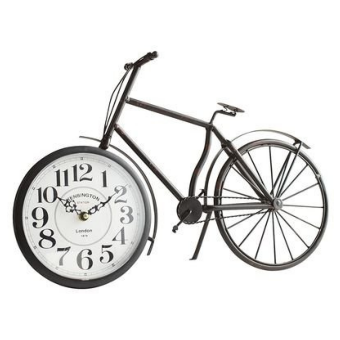

Prediction: a clock on a wall with a clock on it
References:
	A bicycle replica with a clock as the front wheel.
	The bike has a clock as a tire.
	A black metal bicycle with a clock inside the front wheel.
	A bicycle figurine in which the front wheel is replaced with a clock
	A clock with the appearance of the wheel of a bicycle


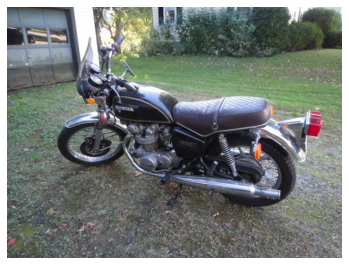

Prediction: a motorcycle parked on the side of a road
References:
	A black Honda motorcycle parked in front of a garage.
	A Honda motorcycle parked in a grass driveway
	A black Honda motorcycle with a dark burgundy seat.
	Ma motorcycle parked on the gravel in front of a garage
	A motorcycle with its brake extended standing outside


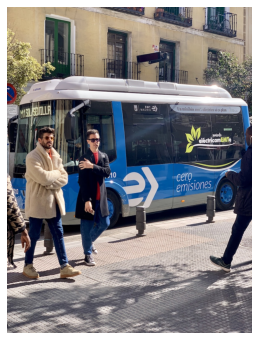

Prediction: a man standing next to a bus on a street


In [50]:
if __name__ == '__main__':
    if "get_ipython" in dir():
        # pyright: reportUndefinedVariable=false
        get_ipython().run_line_magic('matplotlib', 'inline')
    show_model_prediction(SEQ2SEQ_SAMPLES, TRAIN_IMAGE_PATH, INFO_DF_TRAIN, 203564)
    show_model_prediction(SEQ2SEQ_SAMPLES, VAL_IMAGE_PATH, INFO_DF_VAL, 179765)
    test_model_prediction(SEQ2SEQ_SAMPLES, os.path.join(DATASET_PATH, "test", "bus.jpg"))

In [31]:
def dataset_prediction(
    seq2seq: Seq2seqSamples,
    image_dir: str,
    df: pd.DataFrame
) -> Dict[int, List[str]]:
    result = {}
    image_id_list = df["image_id"].to_list()
    for image_id in tqdm(image_id_list):
        image_path = os.path.join(image_dir,  df[df["image_id"] == image_id]["file_name"].iloc[0])
        predictions = seq2seq(image_path, True)
        result[image_id] = predictions
    return result


def load_dataset_prediction(
    export_path: str,
    seq2seq: Seq2seqSamples,
    image_dir: str,
    df: pd.DataFrame
) -> Dict[int, List[str]]:
    if not USE_CACHE or not os.path.isfile(export_path):
        result = dataset_prediction(seq2seq, image_dir, df)
        with open(export_path, "w", encoding="utf8") as f:
            json.dump(result, f)
        return result
    else:
        print("Loading from cache ...")
        with open(export_path, "r", encoding="utf8") as f:
            result = json.load(f)
        return {int(k): v for k, v in result.items()}


In [32]:
if __name__ == '__main__':
    VAL_PREDICTIONS = load_dataset_prediction(
        PREDICTIONS_VAL_PATH,
        SEQ2SEQ_SAMPLES,
        VAL_IMAGE_PATH,
        INFO_DF_VAL
    )

Loading from cache ...


In [33]:
class MeteorMetric:
    def __init__(self, cmd_root: str, jar_path: str):
        self._cmd = ['java', '-jar', '-Xmx2G', jar_path, '-', '-', '-stdio', '-l', 'en', '-norm']
        self._process = subprocess.Popen(self._cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        self._lock = threading.Lock()

    def compute_sentence_score(self, references: List[List[str]], prediction: List[str]) -> float:
        with self._lock:
            stat_output = self._get_stat(references, prediction)
            result = self._get_score([stat_output])

        return result

    def compute_score(self, inputs: List[Tuple[List[List[str]], List[str]]]) -> float:
        assert len(references_list) == len(predictions_list)

        stat_outputs = []
        with self._lock:
            for references, prediction in inputs:
                stat_output = self._get_stat(references, prediction)
                stat_outputs.append(stat_output)
            result = self._get_score(stat_outputs)
        return result

    def compute_scores(self, inputs: List[Tuple[List[List[str]], List[str]]]) -> List[float]:
        assert len(references_list) == len(predictions_list)

        stat_outputs = []
        with self._lock:
            for references, prediction in inputs:
                stat_output = self._get_stat(references, prediction)
                stat_outputs.append(stat_output)
            result = self._get_scores(stat_outputs)
        return result

    def _get_stat(self, references: List[List[str]], prediction: List[str]) -> str:
        references_str_list = [" ".join(s) for s in references]
        score_inputs = ' ||| '.join(('SCORE', ' ||| '.join(references_str_list), " ".join(prediction)))
        self._process.stdin.write(f"{score_inputs}\n".encode())
        self._process.stdin.flush()
        stat_output = self._process.stdout.readline().decode().strip()
        return stat_output

    def _get_score(self, stat_outputs: List[str]) -> float:
        eval_inputs = "EVAL ||| " + " ||| ".join(stat_outputs)
        self._process.stdin.write(f"{eval_inputs}\n".encode())
        self._process.stdin.flush()
        score = float(self._process.stdout.readline().decode().strip())
        return score

    def _get_scores(self, stat_outputs: List[str]) -> List[float]:
        result = []
        for stat_output in stat_outputs:
            self._process.stdin.write(f"EVAL ||| {stat_output}\n".encode())
            self._process.stdin.flush()
            score = float(self._process.stdout.readline().decode().strip())
            result.append(score)
        return result

    def __del__(self):
        with self._lock:
            self._process.stdin.close()
            self._process.kill()
            self._process.wait()

In [34]:
def calculate_score(references: List[List[str]], predict: List[str]) -> Dict[str, float]:
    bleu_smooth_func = SmoothingFunction().method1
    return {
        "BLEU_1-grams": sentence_bleu(references, predict, (1, 0.0, 0.0, 0.0), smoothing_function=bleu_smooth_func),
        "BLEU_2-grams": sentence_bleu(references, predict, (0.5, 0.5, 0.0, 0.0), smoothing_function=bleu_smooth_func),
        "BLEU_3-grams": sentence_bleu(references, predict, (0.333, 0.333, 0.333, 0.0), smoothing_function=bleu_smooth_func),
        "BLEU_4-grams": sentence_bleu(references, predict, (0.25, 0.25, 0.25, 0.25), smoothing_function=bleu_smooth_func)
    }


def model_evaluation(
        predictions: Dict[int, List[str]],
        df: pd.DataFrame,
        captions: Dict[int, List[str]],
        meteor: MeteorMetric
) -> Dict[int, Dict[str, float]]:
    result = {}
    image_id_list = df["image_id"].to_list()
    args = {}
    print("Preparing ...")
    for image_id in tqdm(image_id_list):
        predict = predictions[image_id]
        references = [captions[i] for i in df[df["image_id"] == image_id]["id"]]
        args[image_id] = (references, predict)
    if MULTIPROCESSING:
        print("Calculating BLEU ...")
        with Pool(6) as p:
            pbar = tqdm(total=len(image_id_list))
            for image_id in image_id_list:
                result[image_id] = p.apply_async(calculate_score, args[image_id], callback=lambda *x: pbar.update())
            for k, v in result.items():
                result[k] = v.get()
        print("\nCalculating METEOR ...")
        for k, v in tqdm(args.items()):
            result[k]["METEOR"] = meteor.compute_sentence_score(v[0], v[1])
    else:
        print("Calculating score ...")
        for image_id in tqdm(image_id_list):
            ref, pre = args[image_id]
            result[image_id] = calculate_score(ref, pre)
            result[image_id]["METEOR"] = meteor.compute_sentence_score(ref, pre)
    return result


def load_model_evaluation(
        export_path: str,
        predictions: Dict[int, List[str]],
        df: pd.DataFrame,
        captions: Dict[int, List[str]],
        meteor: MeteorMetric
) -> Dict[int, Dict[str, float]]:
    if not USE_CACHE or not os.path.isfile(export_path):
        result = model_evaluation(predictions, df, captions, meteor)
        with open(export_path, "w", encoding="utf8") as f:
            json.dump(result, f)
        return result
    else:
        print("Loading from cache ...")
        with open(export_path, "r", encoding="utf8") as f:
            result = json.load(f)
        return {int(k): v for k, v in result.items()}


In [35]:
if __name__ == '__main__':
    EVALUATION_SCORES_VAL = load_model_evaluation(
        EVALUATION_VAL_PATH,
        VAL_PREDICTIONS,
        INFO_DF_VAL,
        CLEANED_CAPTIONS_VAL,
        MeteorMetric(EVAL_METEOR_PATH, EVAL_METEOR_JAR_PATH)
    )

Loading from cache ...


Average score of BLEU_1-grams:  0.6788
Average score of BLEU_2-grams:  0.4856
Average score of BLEU_3-grams:  0.3295
Average score of BLEU_4-grams:  0.2283
Average score of METEOR:  0.2424


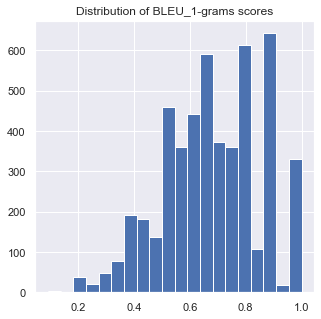

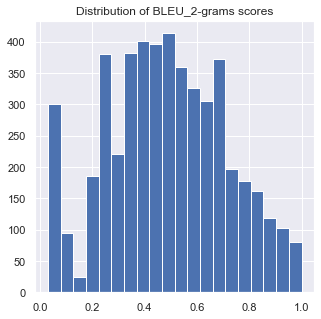

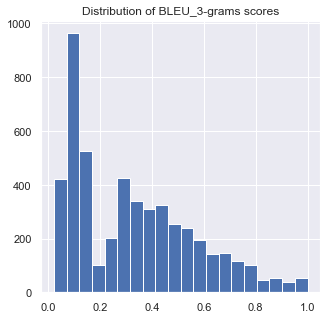

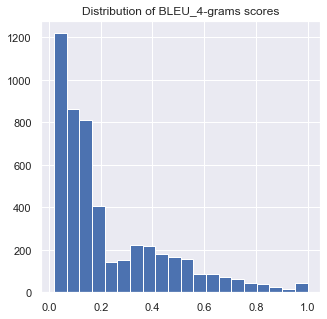

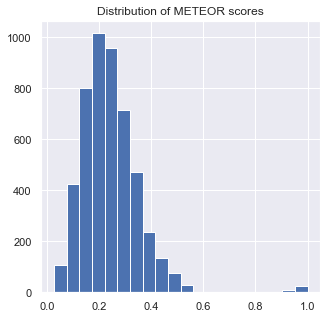

In [51]:
def plot_scores_distribution(name: str, scores: List[float]):
    plt.figure(figsize=(5, 5))
    plt.hist(scores, bins=20)
    plt.title(f"Distribution of {name} scores")
    plt.show()


def print_prediction_compare(scores: List[Tuple[int, float]], predictions: Dict[int, List[str]], df: pd.DataFrame):
    for k, _ in scores:
        references = df[df["image_id"] == k]["caption"].to_list()
        predict = " ".join(predictions[k])
        print("Prediction:", predict)
        print("References:")
        for r in references:
            print(f"\t{r}")


def index_scores(scores: Dict[int, Dict[str, float]]) -> Dict[str, Dict[int, List[float]]]:
    indexed_scores = {}
    for image_id, score in scores.items():
        for name, data in score.items():
            if name not in indexed_scores:
                indexed_scores[name] = {}
            indexed_scores[name][image_id] = data
    return indexed_scores


def analyze_prediction_samples(slice: Tuple[Optional[int], Optional[int]], metric: str, scores: Dict[int, Dict[str, float]], predictions: Dict[int, List[str]], df: pd.DataFrame):
    indexed_scores = index_scores(scores)
    metric_scores = sorted(indexed_scores[metric].items(), key=lambda x: x[1], reverse=True)
    start = slice[0] if slice[0] is not None else 0
    end = slice[1] if slice[1] is not None else len(metric_scores)
    sliced_scores = metric_scores[start:end]
    print_prediction_compare(sliced_scores, predictions, df)


def analyze_model_evaluation(scores: Dict[int, Dict[str, float]]):
    indexed_scores = index_scores(scores)
    for k, v in indexed_scores.items():
        print(f"Average score of {k}: {np.mean(list(v.values())) : .4}")
    if SHOW_IMAGE_AND_PLOT:
        for k, v in indexed_scores.items():
            plot_scores_distribution(k, list(v.values()))


if __name__ == '__main__':
    if "get_ipython" in dir():
        # pyright: reportUndefinedVariable=false
        get_ipython().run_line_magic('matplotlib', 'inline')
    analyze_model_evaluation(EVALUATION_SCORES_VAL)

In [37]:
def convert_flickr_token(token_path: str) -> pd.DataFrame:
    df = pd.read_table(token_path, sep='\t', header=None, names=['image', 'caption'])
    df['image_id'] = df["image"].apply(lambda x: int(x[:x.index(".")]))
    df['file_name'] = df["image"].apply(lambda x: x[:x.index("#")])
    df['id'] = df["image"].apply(lambda x: x[:x.index(".")] + "-" + x[x.rindex("#") + 1:])
    df.drop("image", axis=1, inplace=True)
    return df


def load_flickr_token(export_name: str, token_path: str) -> pd.DataFrame:
    export_path = os.path.join(PREPROCESS_DATA_PATH, export_name)
    if not USE_CACHE or not os.path.isfile(export_path):
        print("Converting ...")
        result = convert_flickr_token(token_path)
        result.to_pickle(export_path)
        return result
    else:
        print("Loading from cache ...")
        return pd.read_pickle(export_path)


In [38]:
if __name__ == '__main__':
    INFO_DF_TEST = load_flickr_token(PREPROCESS_INFO_TEST, FLICKR_TOKEN_PATH)
    CLEANED_CAPTIONS_TEST = load_cleaned_captions(INFO_DF_TEST, PREPROCESS_CAPTION_CLEANED_TEST)

Loading from cache ...
Loading cache from captions_cleaned_test.bin


In [39]:
if __name__ == '__main__':
    TEST_PREDICTIONS = load_dataset_prediction(
        PREDICTIONS_TEST_PATH,
        SEQ2SEQ_SAMPLES,
        TEST_IMAGE_PATH,
        INFO_DF_TEST
    )
    EVALUATION_SCORES_TEST = load_model_evaluation(
        EVALUATION_TEST_PATH,
        TEST_PREDICTIONS,
        INFO_DF_TEST,
        CLEANED_CAPTIONS_TEST,
        MeteorMetric(EVAL_METEOR_PATH, EVAL_METEOR_JAR_PATH)
    )

Loading from cache ...
Loading from cache ...


Average score of BLEU_1-grams:  0.5446
Average score of BLEU_2-grams:  0.3274
Average score of BLEU_3-grams:  0.1887
Average score of BLEU_4-grams:  0.1199
Average score of METEOR:  0.1591


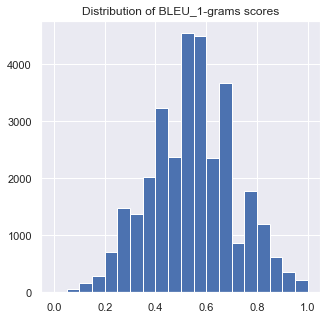

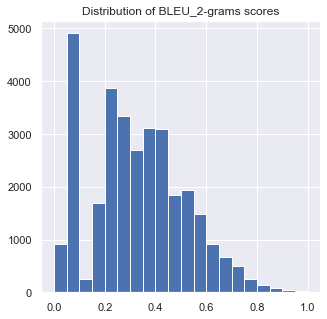

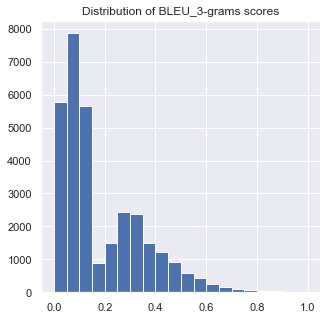

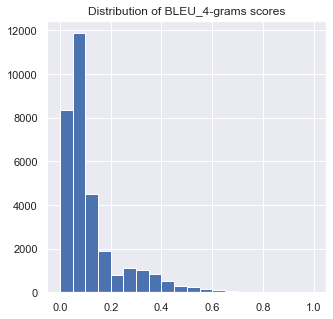

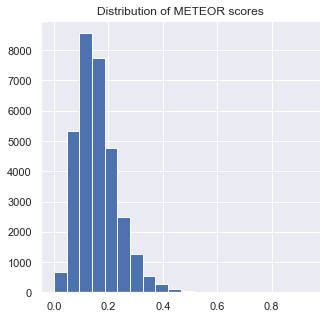

In [52]:
if __name__ == "__main__":    
    if "get_ipython" in dir():
        # pyright: reportUndefinedVariable=false
        get_ipython().run_line_magic('matplotlib', 'inline')
    analyze_model_evaluation(EVALUATION_SCORES_TEST)

In [41]:
# analyze_prediction_samples((None, 10), "METEOR", EVALUATION_SCORES_VAL, VAL_PREDICTIONS, INFO_DF_VAL)
# analyze_prediction_samples((None, 10), "METEOR", EVALUATION_SCORES_TEST, TEST_PREDICTIONS, INFO_DF_TEST)

In [42]:
def analyze_model_evaluation_categories(scores: Dict[int, Dict[str, float]], df: pd.DataFrame) -> pd.DataFrame:
    categories_scores = {}
    for image_id, score in scores.items():
        categories = df[df["image_id"] == image_id]["name"].drop_duplicates(inplace=False).to_list()
        for name, data in score.items():
            if name not in categories_scores:
                categories_scores[name] = {}
            for category in categories:
                if category not in categories_scores[name]:
                    categories_scores[name][category] = []
                categories_scores[name][category].append(data)
    score_table = None
    for score_name, categories in categories_scores.items():
        for category, scores in categories.items():
            categories_scores[score_name][category] = np.mean(scores)
        sub_score_table = pd.DataFrame([[k, v] for k, v in categories_scores[score_name].items()], columns=["category", score_name])
        if score_table is None:
            score_table = sub_score_table
        else:
            score_table = pd.merge(score_table, sub_score_table, on="category")
    assert not score_table.isnull().values.any()
    score_table["Average score"] = score_table[list(categories_scores.keys())].mean(axis=1)
    score_table.sort_values("Average score", ascending=False, inplace=True)
    score_table.reset_index(drop=True ,inplace=True)
    return score_table


def load_model_evaluation_categories(export_path: str, scores: Dict[int, Dict[str, float]], df: pd.DataFrame) -> pd.DataFrame:
    if not USE_CACHE or not os.path.isfile(export_path):
        print("Calculating ...")
        result = analyze_model_evaluation_categories(scores, df)
        result.to_csv(export_path, index=False)
        return result
    else:
        print("Loading from cache ...")
        return pd.read_csv(export_path)

In [43]:
if __name__ == '__main__':
    SCORE_TABLE_VAL = load_model_evaluation_categories(
        CATEGORIES_SCORE_TABLE_VAL_PATH, 
        EVALUATION_SCORES_VAL, 
        INFO_CATEGORIES_VAL
    )

Loading from cache ...


In [44]:
def decoder_export(vocab_path: str, decoder_path: str, export_dir: str, replace_export: bool):
    if replace_export or not (os.path.isdir(export_dir) and len(os.listdir(export_dir)) > 0):
        if os.path.isdir(export_dir) and len(os.listdir(export_dir)) > 0:
            print("Replace export model!")
            shutil.rmtree(export_dir)
        os.makedirs(export_dir)
        vocab = Vocabulary.load(vocab_path)
        vocab.save(os.path.join(export_dir, "vocab.txt"))
        decoder = get_export_decoder_model(decoder_path, len(vocab)).to("cpu")
        # decoder.export_onnx(export_dir, False)
        decoder.export_torchscript(export_dir, False)
        print(f"Model exported to: {export_dir}")
    else:
        print("Export model exists!")


In [45]:
if __name__ == '__main__':
    decoder_export(
        os.path.join(PREPROCESS_DATA_PATH, PREPROCESS_VOCABULARY),
        DECODER_MODEL_PATH,
        EXPORT_MODEL_PATH,
        False
    )

Export model exists!
